# Project of Data Mining for networks


# Teacher: Frédéric Giroire

# Building the end host graphlets correspending to flows in annotated-trace.csv

In [65]:
# we will apply the Activity graphlet and Profile graphlet to 
#the exapmle presented in article than we will 
#apply it to data set: annotated_trace 

In [3]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
#Data = (pd.read_csv('data.csv',header=None)).iloc[:,0:5].drop_duplicates()
Data = (pd.read_csv('annotated-trace.csv',header=None)).
                                        iloc[9000:,0:6].drop_duplicates()
predict_data = (pd.read_csv('not-annotated-trace.csv',header=None)).
                                        iloc[20000:,0:5].drop_duplicates()


In [135]:
print(Data)



         0    1   2   3   4       5
9000   557  319   6  80  25  normal
9001   858   59   6  80  20  normal
9002   411  172   1  23  80  normal
9003   261  318   6  80  23  normal
9004   497   25   6  22  22  normal
...    ...  ...  ..  ..  ..     ...
10065  130  854   6  79  25  normal
10066  803  463   1  22  53  normal
10067  550  325   6  53  80  normal
10068  272  999  17  22  79  normal
10069  475  149   6  22  23  normal

[1070 rows x 6 columns]


In [120]:
Data = (pd.read_csv('Data.csv',header=None)).iloc[:,0:6].drop_duplicates()

In [121]:
def Activity(source):
    Specific_data = Data.loc[Data[0] == int(source),:]
    G=nx.Graph()
    G.add_nodes_from(["src_ip"+str(source)])
    for i in range(len(Specific_data)):
        G.add_nodes_from(["dest_ip:"+str(Specific_data.iloc[i,1]),"dest_ipp:"+str(Specific_data.iloc[i,1]),
                          "prot:"+str(Specific_data.iloc[i,2]),"src_port"+str(Specific_data.iloc[i,3]),
                          "des_port"+str(Specific_data.iloc[i,4])])
        G.add_edges_from([("src_ip"+str(source),"prot:"+str(Specific_data.iloc[i,2])),
                          ("prot:"+str(Specific_data.iloc[i,2]),"dest_ip:"+str(Specific_data.iloc[i,1])),
                          ("dest_ip:"+str(Specific_data.iloc[i,1]),"src_port"+str(Specific_data.iloc[i,3])),
                          ("src_port"+str(Specific_data.iloc[i,3]),"des_port"+str(Specific_data.iloc[i,4])),
                          ("des_port"+str(Specific_data.iloc[i,4]),"dest_ipp:"+str(Specific_data.iloc[i,1]))])              
    return G

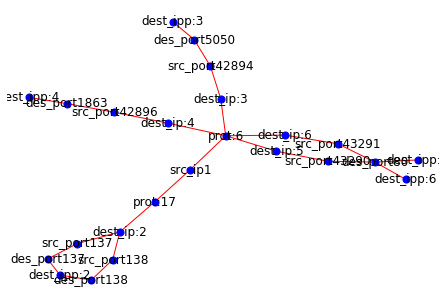

In [122]:
nx.draw(Activity(1), with_labels=True, node_color="b",edge_color="r",node_size=50)

In [18]:
def Profile(source,state=True):
    if state:
        Specific_data = Data.loc[Data[0] == source,:]
    else:
        Specific_data = predict_data.loc[predict_data[0] == source,:]
    Specific_data.index = [i for i in range(len(Specific_data))]
    Significant_Flows=[]
    Non_Significant_Flows=[]
    for i in range(len(Specific_data)):
        for j in range(len(Specific_data)):
            if i==j:
                continue
            if Specific_data.iloc[i,1] == Specific_data.iloc[j,1] or Specific_data.iloc[i,
                            3] == Specific_data.iloc[j,3] or Specific_data.iloc[i,4] == Specific_data.iloc[j,4]:
                Significant_Flows.append(i)
                break

    for i in Specific_data.index:
        if i not in Significant_Flows:
            Non_Significant_Flows.append(i)
    Specific_data = Specific_data.drop(Non_Significant_Flows)
    #Ploting the graph with networkx

    G=nx.Graph()
    G.add_nodes_from(["src_ip"+str(source)])
    for i in range(len(Specific_data)):
        G.add_nodes_from(["dest_ip:"+str(Specific_data.iloc[i,1]),"dest_ipp:"+str(Specific_data.iloc[i,1]),
                          "prot:"+str(Specific_data.iloc[i,2]),"src_port"+str(Specific_data.iloc[i,3]),
                          "des_port"+str(Specific_data.iloc[i,4])])
        G.add_edges_from([("src_ip"+str(source),"prot:"+str(Specific_data.iloc[i,2])),
                          ("prot:"+str(Specific_data.iloc[i,2]),"dest_ip:"+str(Specific_data.iloc[i,1])),
                          ("dest_ip:"+str(Specific_data.iloc[i,1]),"src_port"+str(Specific_data.iloc[i,3])),
                          ("src_port"+str(Specific_data.iloc[i,3]),"des_port"+str(Specific_data.iloc[i,4])),
                          ("des_port"+str(Specific_data.iloc[i,4]),"dest_ipp:"+str(Specific_data.iloc[i,1]))])              
    return G

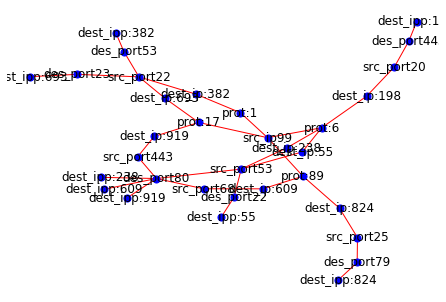

In [126]:
Data = (pd.read_csv('annotated-trace.csv',header=None)).iloc[:,0:6].drop_duplicates()
nx.draw(Activity(99), with_labels=True, node_color="b",edge_color="r",node_size=50)

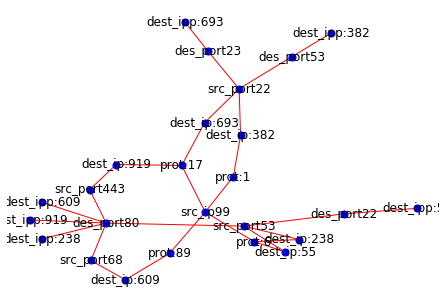

In [127]:
nx.draw(Profile(99), with_labels=True, node_color="b",edge_color="r",node_size=50)

# Building the end host models using the random walk kernel 

In [66]:
# we will build the end host models using the random walk kernel, in two ways 
# first we  will use the kernel trick then we will do the explicit mapping to build our model

In [136]:

def Kernel(G1,G2,landa):
    a=nx.tensor_product(G1,G2)
    a=nx.adjacency_matrix(a).todense()
    ep=np.column_stack(np.ones(len(a)))
    
    iden=np.eye(len(a),len(a))
    inverse= (iden-landa*a).I
    z=np.dot(ep,inverse)
    value =np.dot(z,ep.transpose()) 
    return value

In [137]:
def Malicious(ip):
    for i in range(len(Data)):
        if(Data.iloc[i,0]==ip and Data.iloc[i,5]=="anomaly"):
            return 1
    return 0
def kernelTrick(landa):
    y=[]
    c1=0
    c2=0
    src_ip=Data.loc[:,0].drop_duplicates()
    M=np.zeros((len(src_ip),len(src_ip)))
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        if i in src_ip.keys():
            y.append(Malicious(src_ip[i]))
            G1=Profile(src_ip[i])
            for j in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
                if j in src_ip.keys():
                    G2=Profile(src_ip[j])
                    M[c1][c2]=Kernel(G1,G2,landa)
                    c1+=1
            c2+=1
            c1=0
    return (M,y) 
            

In [138]:
c,m=kernelTrick(0.6)
print(c)
print(m)
    

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [141]:
from sklearn import svm
kernel_trick_Svm=svm.SVC(kernel='precomputed')
kernel_trick_Svm.fit(c,m)





SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [142]:
from numpy.linalg import matrix_power
def RandomWalkkernel(G1,G2,k,landa=0.5):
    a1=nx.convert_matrix.to_numpy_array(G1)
    b1=nx.convert_matrix.to_numpy_array(G2)
    dot_product=nx.tensor_product(G1,G2)
    dot_product=nx.adjacency_matrix(dot_product).todense()
    result=0
    val=np.zeros((len(a1)*len(b1),len(a1)*len(b1)))
    for l in range(k):
        val+=(landa**l)*matrix_power(dot_product, l)
        
    for i in range(len(a1)*len(b1)):
        for j in range(len(a1)*len(b1)):
            result+=val[i][j]
    return result
            
    

In [143]:
def kernel2(k):
    y=[]
    c1=0
    c2=0
    src_ip=Data.loc[:,0].drop_duplicates()
    M=np.zeros((len(src_ip),len(src_ip)))
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        if i in src_ip.keys():
            y.append(Malicious(src_ip[i]))
            G1=Profile(src_ip[i])
            for j in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
                if j in src_ip.keys():
                    G2=Profile(src_ip[j])
                    M[c1][c2]=RandomWalkkernel(G1,G2,k)
                    c1+=1
            c2+=1
            c1=0
    return (M,y) 
            

In [144]:
c,m=kernel2(4)
print(c)
print(m)
    

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [147]:
kernel4=svm.SVC(kernel='precomputed')
kernel4.fit(c,m)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [148]:
c,m=kernel2(10)
print(c)
print(m)
    

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [149]:
kernel10=svm.SVC(kernel='precomputed')
kernel10.fit(c,m)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='precomputed', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
c,m=kernel2(20)
print(c)
print(m)

In [ ]:
kernel20=svm.SVC(kernel='precomputed')
kernel20.fit(c,m)

In [ ]:
c,m=kernel2(50)
print(c)
print(m)

In [ ]:
kernel50=svm.SVC(kernel='precomputed')
kernel50.fit(c,m)

In [ ]:
c,m=kernel2(100)
print(c)
print(m)

In [ ]:
kernel100=svm.SVC(kernel='precomputed')
kerel100.fit(c,m)

# Prediction of anomalous traffic using the previous built model 

In [151]:
def PredictkernelTrick(landa=0.6):
    c1=0
    c2=0
    y=[]
    src_ip=predict_data.loc[:,0].drop_duplicates()
    M=np.zeros((len(src_ip),len(src_ip)))
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        if i in src_ip.keys():
            G1=Profile(src_ip[i],state=False)
            for j in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
                if j in src_ip.keys():
                    G2=Profile(src_ip[j],state=False)
                    M[c1][c2]=Kernel(G1,G2,landa)
                    c1+=1
            c2+=1
            c1=0
    return M 

In [ ]:
def Malicious_predict():
    def predict(ip):
        for i in range(len(predict_data)):
            if (predict_data.isnull().iloc[i,5]):
                return 0.5
            if(predict_data.iloc[i,0]==ip and predict_data.iloc[i,5]=="anomaly"):
                return 1
        return 0
    Y_test=[]
    src_ip=predict_data.loc[:,0].drop_duplicates()
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        Y_test.append(predict(src_ip[i]))
    return Y_test


In [ ]:
kernel4_predict=kernel4.predict(X_test)
display(kernel4_predict)

In [ ]:
kernel10_predict=kernel10.predict(X_test)
display(kernel10_predict)

In [ ]:
kernel20_predict=kernel20.predict(X_test)
display(kernel20_predict)

In [ ]:
kernel50_predict=kernel50.predict(X_test)
display(kernel50_predict)

In [ ]:
kernel100_predict=kernel100.predict()
display(kernel100_predict)

In [ ]:
x=[i for in range(len(predict_data.loc[:,0].drop_duplicates()))]
plt.scatter(x,Malicious_predict())

In [7]:
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
columns=['srcIp', 'dstIp','proto','portSrc', 'portDst','anomaly']
OurData=pd.read_csv("annotated-trace.csv",names=columns)
x=OurData.drop('anomaly',axis=1)
y=OurData['anomaly']

x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=0.10)

#OurData=pd.read_csv("not-annotated-trace.csv",names=columns)
#x_test=OurData.drop('anomaly',axis=1)
#y_test=OurData['anomaly']


Svc_Cl=svm.SVC(kernel='poly',degree=10)
Svc_Cl.fit(x_train,y_train)
y_pred=Svc_Cl.predict(x_test)

print(y_pred)
dataframe=pd.DataFrame(y_pred)
dataframe.to_excel("output2.xlsx",
             sheet_name='Sheet_name_1')  
print(classification_report(y_test,y_pred))

C:\Users\user\Documents\temp\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\user\Documents\temp\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


['normal' 'normal' 'normal' ... 'normal' 'normal' 'normal']
              precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00         5
      normal       1.00      1.00      1.00      1002

    accuracy                           1.00      1007
   macro avg       0.50      0.50      0.50      1007
weighted avg       0.99      1.00      0.99      1007



# Question 11: the modeling and detection phases using the ideal kernel for subgraph of size 5


In [8]:
G2 = nx.Graph()
G2.add_nodes_from([0,1,2,3,4])
G2.add_edges_from([(0,1),(1,2),(2,3),(3,0),(2,4)])
def Node(i):
    Ma = []
    for j in range(len(G2.nodes)):
        Ma2=[]
        A = list(nx.all_simple_paths(G2,i,j))
        for k in A:
            if(len(k)==3):
                Ma2.append(k)
        Ma.extend(Ma2)
    return Ma

Final=[]
for i in range(len(G2.nodes)):
    Inter = Node(i)
    Final.extend(Inter)
print(len(Final)/2)


6.0


In [31]:
def idealKernel(G):
    def idealK(i):
        Ma = []
        for j in range(len(G.nodes)):
            Ma2=[]
            A = list(nx.all_simple_paths(G,i,j))
            for k in A:
                if(len(k)==5):
                    Ma2.append(k)
            Ma.extend(Ma2)
        return Ma

    Final=[]
    for i in range(len(G2.nodes)):
        Inter = Node(i)
        Final.extend(Inter)
    return int(len(Final)/2)


In [32]:
G2 = nx.Graph()
G2.add_nodes_from([0,1,2,3,4])
G2.add_edges_from([(0,1),(1,2),(2,3),(3,0),(2,4)])
idealKernel(G2)

6

In [51]:
def Malicious(ip):
    for i in range(len(Data)):
        if(Data.iloc[i,0]==ip and Data.iloc[i,5]=="anomaly"):
            return 1
    return 0
def idealkernelT():
    y=[]
    src_ip=Data.loc[:,0].drop_duplicates()
    M=list(np.zeros(len(src_ip)))
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        if i in src_ip.keys():
            y.append(Malicious(src_ip[i]))
            G1=Profile(src_ip[i])
            M.append(idealKernel(G1))
            
    return (M,y) 

In [55]:
x_train,y_train=idealkernelT()

print(x_train)
print()
print(y_train)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [56]:
from sklearn import svm
clf=svm.SVC()
x=np.array(x_train)
x_train1 = np.reshape(x, (-1, 2))
clf.fit(x_train1,y_train)

C:\Users\user\Documents\temp\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [59]:
def PredictIdealKernel():
    src_ip=predict_data.loc[:,0].drop_duplicates()
    M=list(np.zeros((len(src_ip))))      
    for i in range(src_ip.keys()[0],src_ip.keys()[-1]+1):
        if i in src_ip.keys():
            G1=Profile(src_ip[i],state=False)
            M.append(idealKernel(G1))
    return M 
           

In [70]:
x_test=PredictIdealKernel()
print(x_test)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [63]:
x=np.array(x_test)
x_test1 = np.reshape(x, (-1, 2))
value_ideal_kernel=clf.predict(x_test1)
display(value_ideal_kernel)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])